# Proyecto Final / Fundamentos de Analítica 1

### Integrantes del grupo

- Mary Yuliana Jaramillo
- Juan Fernando Gómez
- Melina Imbachi
- Daniel Rengifo

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')

import seaborn as sns
import numpy as np


from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split

from dython.nominal import associations
import math

import warnings
warnings.filterwarnings('ignore')

In [54]:
! python --version

Python 3.11.5


In [55]:
train = pd.read_csv('Train.csv')

In [56]:
train.head(2)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A


In [57]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


## Limpieza y EDA

### a. Control de calidad de los datos.
En esta sección se realiza una revisión del tipo de variables y el número de datos faltantes en el data set de entrenamiento.

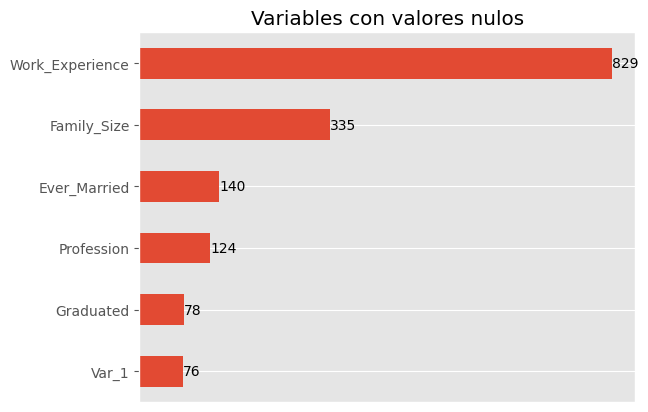

In [58]:
ax = train.isnull().sum()[train.isnull().sum()>0].sort_values().plot(kind = 'barh')
ax.bar_label(ax.containers[0])
ax.set_title('Variables con valores nulos')
ax.get_xaxis().set_visible(False)
plt.show()

In [59]:
train.isnull().sum(axis = 1).value_counts()

0    6665
1    1244
2     140
3      18
4       1
Name: count, dtype: int64

* En el control de calidad de los datos, se encuentrá que el dataset consta de 8.608 observaciones y 11 variables, las cuales todas tienen el tipo de variable esperado. 

* Con respecto a los datos faltantes, la variable ***Work_Experience*** es la que mayor cantidad de nulos tiene (829), seguido de ***Family_Size*** (335).

* En cuanto a el número de nulos por observación se encuentra que, existen 6.665 observaciones completas, 1.244 observaciones con un dato faltante, 140 observaciones con 2 datos faltantes y 19 observaciones con al menos 3 columnas sin dato.

### b. Visualización de la información

In [60]:
## Se elimina el ID, dado que no es necesario para el análsis
train.drop('ID', axis = 1, inplace = True)

In [8]:
## Se define la función que separa las variables categóricas, numéricas y la variable independiente.
def SepararNumCate(df):
    numericas = df.select_dtypes(include = 'number').columns
    categoricas = df.select_dtypes(exclude = 'number').columns.to_list()
    categoricas.remove('Segmentation') ## REMOVES THE TARGET VARIABLE
    target = df.loc[:,'Segmentation']
    return df.loc[:,numericas].copy(), df.loc[:,categoricas].copy(), target

In [61]:
num, categ, target = SepararNumCate(train)

* **Balanceo del dataset**

  Cada una de las categorías de la variable Segmentation contiene alrededor del 25% de las observaciones, por lo que al dataset no hay que realizarle procesos de balanceo.

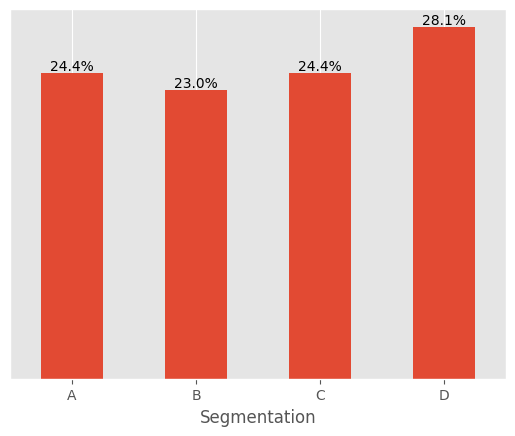

In [62]:
ax = train.Segmentation.value_counts(normalize = True).sort_index().plot( kind = 'bar')
ax.get_yaxis().set_visible(False)
labels = (train.Segmentation.value_counts(normalize = True).sort_index()*100).round(1).astype('str') + '%' ## ETIQUETA DE LAS BARRAS QUE SE MUESTRE EN %
ax.tick_params(axis='x', rotation=0)  ## ROTAR LAS ETIQUETAS DEL EJE X
for container in ax.containers:
    ax.bar_label(container, labels=labels)
plt.show()

* **Segmentación vs Edad:**

    En el siguiente gráfico se observa que el grupo D, tiene en promedio una edad menor que el resto de grupos, que tienen edades promedio por encima de 44 años, los grupos de las segmentación B y C tiene distribuciones parecidas de la variable edad.

ValueError: Cannot subset columns with a tuple with more than one element. Use a list instead.

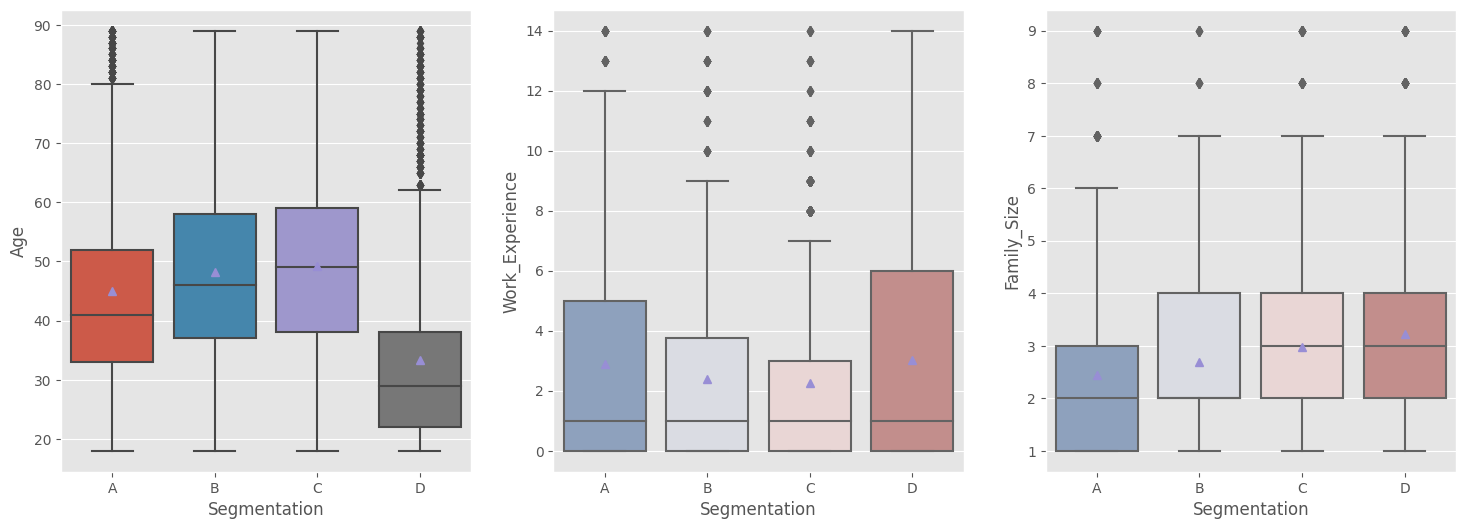

In [66]:
fig, (ax1 ,ax2, ax3) = plt.subplots(1,3, figsize = (18,6))
#sns.histplot(data = train, x  = 'Age', hue = 'Segmentation', kde = True, ax = ax1)
sns.boxplot(data = train, x = 'Segmentation', y = 'Age', order = train.Segmentation.sort_values().unique(), ax = ax1, showmeans = True)
sns.boxplot(data = train, x = 'Segmentation', y = 'Work_Experience', order = train.Segmentation.sort_values().unique(), ax = ax2, showmeans = True,palette="vlag")
sns.boxplot(data = train, x = 'Segmentation', y = 'Family_Size', order = train.Segmentation.sort_values().unique(), ax = ax3, showmeans = True, palette="vlag")
# Calcular la media por categoría
means = train.groupby('Segmentation')['Age', 'Work_Experience', 'Family_Size'].mean().values

# Agregar líneas para la media y la mediana
#for i in range(len(train.Segmentation.sort_values().unique())):
 #   plt.text(i, means[i], f'{means[i]:.2f}', ha='center', va='bottom', color='blue', fontsize=8)

# Mostrar el gráfico
plt.show()


* **Segmentación vs Experiencia laboral**

    En la gráfica siguiente se observa que el promedio de experiencia laboral para todas las categorías de Segmentation se encuentra entre los 2 y 3 años, también es posible identificar que el grupo D es el que más experiencia tiene puesto que un 75% de los individuos tienen una experiencia laboral de 6 años o menos, y el grupo C es el que menos experiencia tiene ya que el 75% de los individuos tienen una experiencia de 3 años o menos.


* **Segmentation vs Family Size**

  El tamaño del núcleo familiar tiene una distribución similar para los segmentos B, C y D, donde el 75% de los individuos cada uno de estos grupos tiene un núcleo familiar conformado por 4 o menos personas, por otra parte el núcleo familiar del Segmento A es más reducido donde el 75% de los individuos tienen un núcleo familiar de 3 o menos personas.

c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

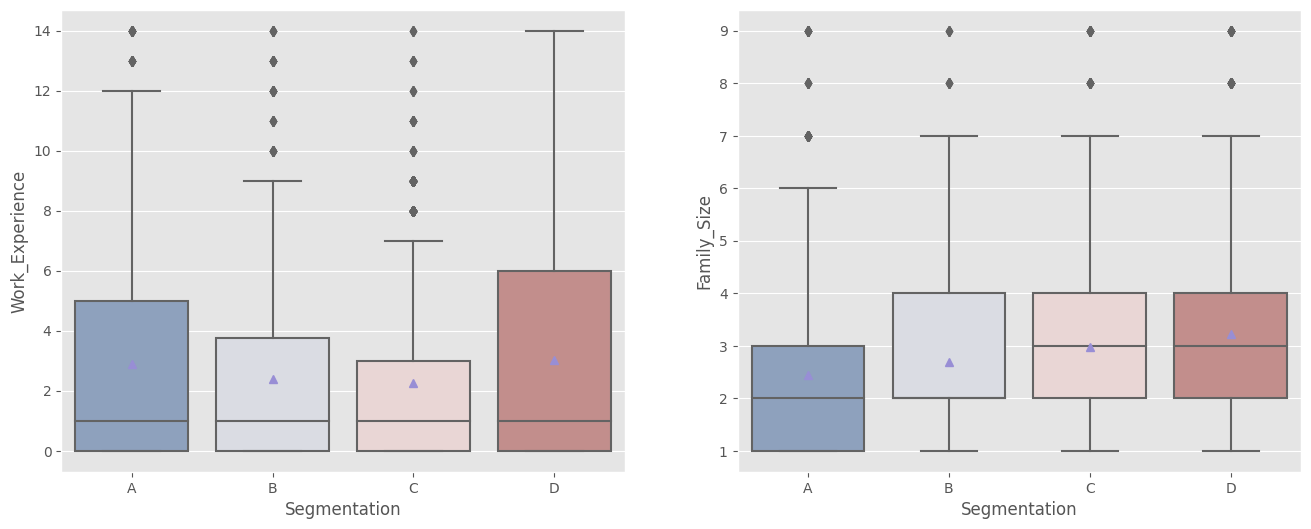

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,6))
sns.boxplot(data = train, x = 'Segmentation', y = 'Work_Experience', order = train.Segmentation.sort_values().unique(), ax = ax1, showmeans = True,palette="vlag")
sns.boxplot(data = train, x = 'Segmentation', y = 'Family_Size', order = train.Segmentation.sort_values().unique(), ax = ax2, showmeans = True, palette="vlag")
plt.show()

* **Género vs Segmentación**

   Con respecto a la distribución del género por Segmentación, la participación en todos los grupos de ambos géneros es similar a excepción del grupo D, donde la participación de los hombres es casi del 60%.

* **Ever_Married vs Segmentación**
  
  La variable categórica que toma en cuenta si el individuo ha estado casado alguna vez presenta la siguiente distribución: en los grupos A, B y C la mayoría de personas han estado casados, teniendo una mayor participación elos grupos A y B alcanzando casi el 80%. El grupo D por el contrario más del 70% de los individuos no han estado casados, este grupo como se vió en anteriores gráficas es el grupo con menor promedio de edad.
  

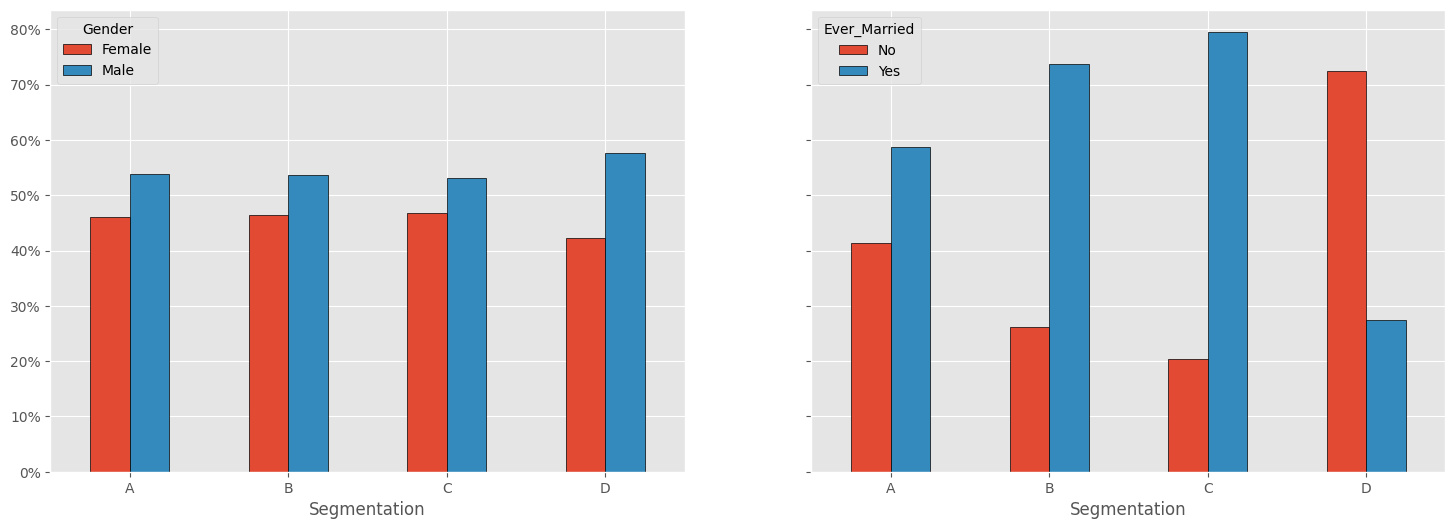

In [106]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (18,6), sharey = True)
pd.crosstab(train.Segmentation,train.Gender,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax1, edgecolor = 'black')
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax1.tick_params(axis='x', rotation=0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax1.legend(loc = 'upper left', title = 'Gender')

pd.crosstab(train.Segmentation,train.Ever_Married,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax2, edgecolor = 'black')
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax2.tick_params(axis='x', rotation=0) 
plt.show()


* **Graduated vs Segmentation**

    La variable binaria que captura si el individuo se graduó sigue el comportamiento siguiente diferenciándola por la Segmentación: En los grupos A, B y C más del 60% son graduados, caso contrario en el grupo D donde poco más del 60% de los individuos no son graduados.


* **Spending_Score vs Segmentation**
    La variable categórica que captura si el puntaje de consumo es bajo, medio o alto presenta la siguiente distribución: Los grupos A, B y D predominan las personas que tienen un consumo bajo, siendo en el grupo D casi la totalidad de personas que tienen un consumo bajo, por su parte en el grupo C  predomina el consumo promedio con un poco más del 40%.

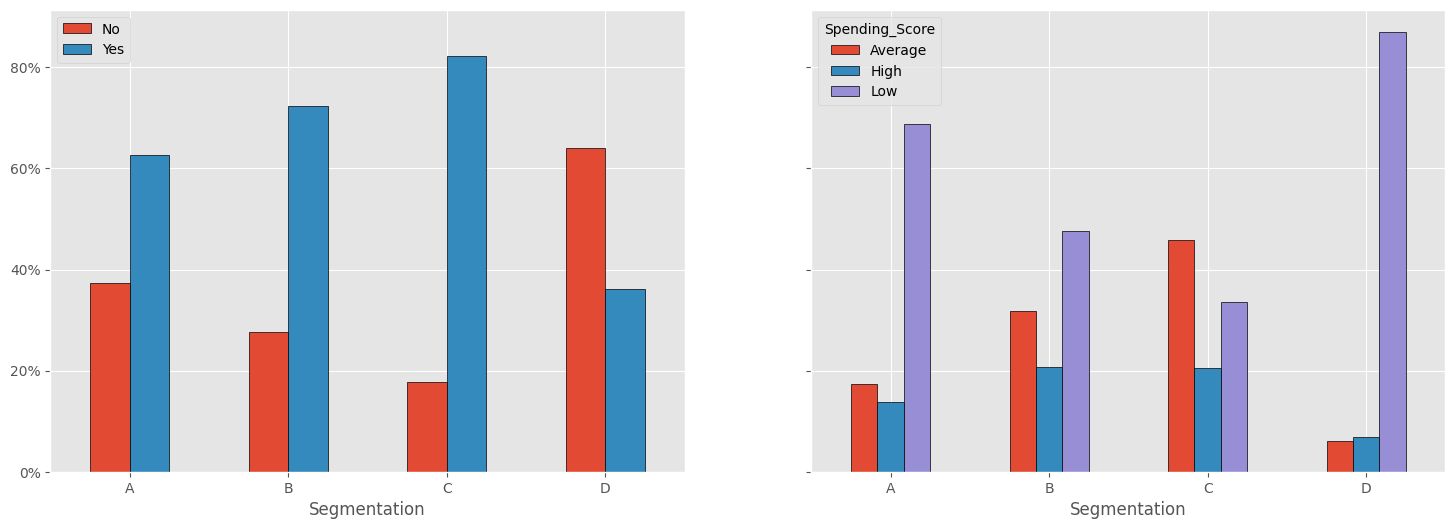

In [110]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (18,6), sharey = True)
pd.crosstab(train.Segmentation,train.Graduated,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax1, edgecolor = 'black')
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax1.tick_params(axis='x', rotation=0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax1.legend(loc = 'upper left')

pd.crosstab(train.Segmentation,train.Spending_Score,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax2, edgecolor = 'black')
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax2.tick_params(axis='x', rotation=0) 
plt.show()


* **Profession vs Segmentation**
  
  Con respecto a la profesión del cliente:
    - El grupo A la mayor participación la tienen los artistas con casi el 30% de los individuos seguido de los profesionales del entretenimiento.
    - El grupo B la mayor participación la tienen los artistas con más del 40% de los individuos seguido por los profesionales del entretenimiento.
    - El grupo C la mayor participación la tienen los artistas con más del 50% de los individuos seguido por los ejecutivos.
    - El grupo D la mayor participación la tienen los profesionales de la salud con más del 40% seguido por los doctores y profesionales del entretenamiento.
    
      
* **Var_1 vs Segmentation**

  Con respecto a una categoría anónima que se le asigna a cada cliente la categoría 6 tiene la mayor participación en todos los segmentos con más del 60% de todos los individuos para los grupos A, B y C, y más del 50% en el grupo D

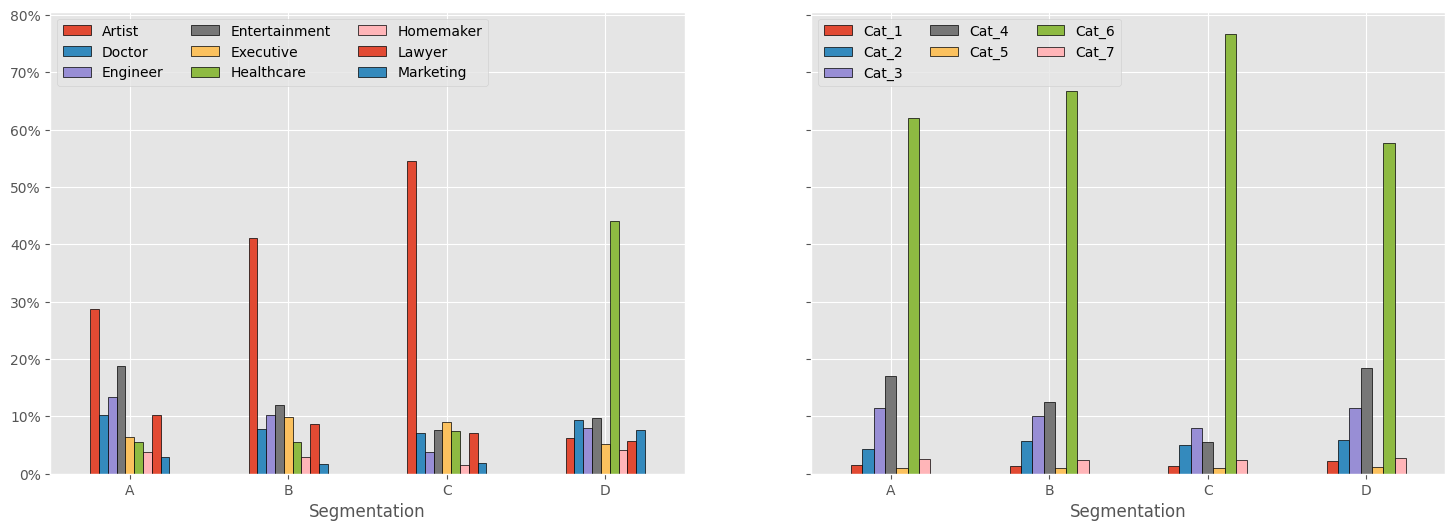

In [113]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (18,6), sharey = True)
pd.crosstab(train.Segmentation,train.Profession,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax1, edgecolor = 'black')
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax1.tick_params(axis='x', rotation=0)  ## ROTAR LAS ETIQUETAS DEL EJE X
ax1.legend(loc = 'upper left', ncols = 3)

pd.crosstab(train.Segmentation,train.Var_1,train.Age,aggfunc='count', normalize = 'index').plot(kind = 'bar', ax = ax2, edgecolor = 'black')
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax = 1,decimals = 0))  ## MUESTRA LOS TICKS DEL EJE Y EN PORCENTAJE
ax2.tick_params(axis='x', rotation=0) 
ax2.legend(loc = 'upper left', ncols = 3)
plt.show()


In [ ]:
# Matriz de correlación
# Importante para conocer la correlación entre cada par de variables
# Las variables independientes a utilizar deberían estar altamente correlacionadas con la objetivo
# Se deben evitar problemas de multicolinealidad
# Las variables independientes no deben estar correlacionadas entre sí
# Si las variables independientes se encuentran altamente correlacionadas, el modelo puede presentar problemas
# al momento de entrenarlo e interpretarlo
# No se podría aislar la relación entre cada variable independiente y la dependiente
# Si no se pueden aislar los efectos, se pueden confundir dichos efectos
# Cuando las variables independientes están muy correlacionadas los cambios en una variable están asociados 
# con cambios en otra variable y, por tanto, los coeficientes de regresión del modelo ya no van a medir el 
# efecto de una variable independiente sobre la respuesta manteniendo constante, o sin variar, el resto 
# de predictores. 
# Al contar con variables categóricas (la dependiente y varias dependientes) no podemos utilizar
# la matriz de correlación clásica que utiliza el coeficiente de correlación de Pearson
# ya que este tan sólo nos sirve para relación entre variables continuas.
# En este caso utilizamos la función associations de dython que utiliza el coeficiente de
# Pearson para continuas-continuas, la razón de correlación continuas-categóricas y
# Cramer's V o Theil's U para categóricas-categóricas

##########################################
### APRENDER A INTERPRETAR ESTA ASOCIACIÓN
###########################################

complete_correlation= associations(train, figsize=(20,20))


In [ ]:
sns.pairplot(data = train[['Age' ,'Work_Experience']])
plt.show()

### c. Extracción de información de los datos

### d. Comprensión y limpieza de datos


In [5]:
## CONTROL DE CALIDAD DE LAS VARIABLES CATEGÓRICAS
for i in train.select_dtypes(exclude = 'number').columns:
    print(f'Categorías de la variable "{i}" ',train[i].unique(),'\n')

Categorías de la variable "Gender"  ['Male' 'Female'] 

Categorías de la variable "Ever_Married"  ['No' 'Yes' nan] 

Categorías de la variable "Graduated"  ['No' 'Yes' nan] 

Categorías de la variable "Profession"  ['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing' nan] 

Categorías de la variable "Spending_Score"  ['Low' 'Average' 'High'] 

Categorías de la variable "Var_1"  ['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' nan 'Cat_5'] 

Categorías de la variable "Segmentation"  ['D' 'A' 'B' 'C'] 



Para elegir qué se va a realizar con respecto a los valores faltantes se proponen 3 estrategias que se pondrán a prueba:

> - 1. Un data set de entrenamiento eliminando todos las observaciones que tengan al menos 1 dato faltante, lo que representa quedarse con un 75% del data set de entrenamiento inicial.

> - 2. Un data set de entrenamiento donde se eliminan las observaciones que tienen 2 o más datos nulos y a la observación que quede con dato un nulo se le asigna el valor del dato, mediante algún método de imputación.

> - 3. Un data set donde no se elimina ningún registro, se asigna el valor de los datos por algún método de imputación.

Después de entrenados los modelos, se realizará la evaluación del desempeño de los modelos empleando cada uno de los data sets.

Se definen un dataset por cada uno de los escenarios propuestos anteriormente

### Estrategia 1

No hay que hacer ningún tratamiento de imputación, sólo eliminar las filas que contengan NA's.

In [ ]:
train1 = train.dropna( axis = 0).copy()

### Estrategia 2

In [ ]:
train2 = train.drop(train.loc[train.isna().sum(axis = 1) >= 2].index).copy()

<font color='red'> HACER UN PIPELINE QUE SEPARE LAS VARIABLES NUMÉRICAS Y CATEGÓRICAS </font>

<font color='yellow'> HACER UN PIPELINE QUE HAGA LAS IMPUTACIONES </font>

### Estrategia 3

In [ ]:
train3 = train.copy()

### Estrategia 4

#### Separar variables para imputar

In [6]:
## SEPARAMOS LAS VARIABLES CATEGÓRICAS Y NUMÉRICAS
numerical_x = train[train.select_dtypes(include = 'number').columns].copy()
categorical_x = train[train.select_dtypes(exclude = 'number').columns].drop('Segmentation', axis = 1).copy()
y = train['Segmentation']

- SE DEBE:
    - ESTANDARIZAR LAS VARIABLES NUMÉRICAS
    - ONE HOT ENCODER CON LAS VARIABLES CATEGÓRICAS
    - UNIRLOS EN UN DATASET
        > - PROBAR DIFERENTES MÉTODOS DE IMPUTACIÓN, MEDIA, MEDIANA
        > - EVALUARLOS Y DEFINIR CON CUÁL MÉTODO SE QUEDA

    

In [7]:
### SE ESTANDARIZAN LAS NUMÉRICAS Y SE HACE ONE HOT ENCODING CON LAS CATEGÓRICAS
numerical_std = pd.DataFrame(StandardScaler().fit_transform(numerical_x), columns = numerical_x.columns)
categorical_ohe = pd.get_dummies(categorical_x, dtype = np.int8)

### SE UNEN AMBOS TIPOS DE VARIABLES
x_1 = pd.concat([numerical_std, categorical_ohe], axis = 1)


#### PREGUNTAR O AVERIGUAR SI LAS DUMMIES SE DEBEN ESTANDARIZAR?????


####  - SimpleImputer

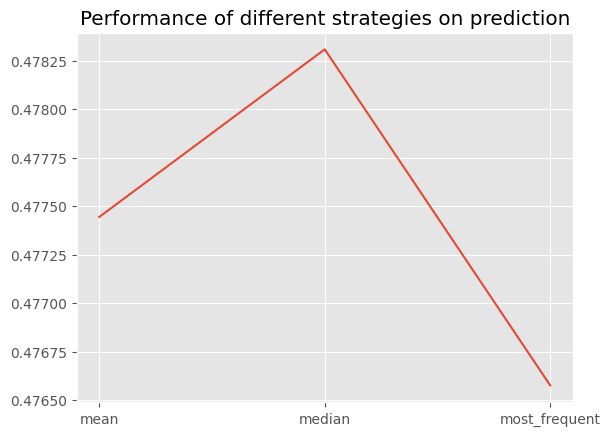

In [12]:
scores_simpleImput = []

for i in ['mean', 'median','most_frequent']: #### REVISAR ESTO TAMBIÉN
    imputer = SimpleImputer(strategy = i)
    x_simpImp = pd.DataFrame(imputer.fit_transform(x_1), columns = x_1.columns)
    classifier = KNeighborsClassifier()
    classifier.fit(x_simpImp, train['Segmentation'])
    scores_simpleImput.append(cross_val_score(classifier,x_simpImp, train['Segmentation'], cv = 10, scoring = 'accuracy').mean())

plt.plot(['mean', 'median','most_frequent'],scores_simpleImput)
plt.title('Performance of different strategies on prediction')
plt.show()

#### - KNNImputer

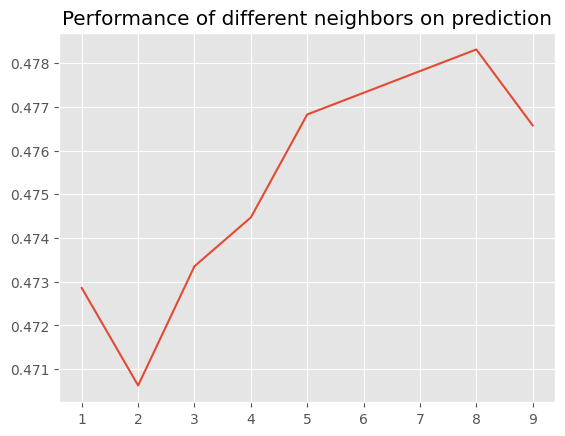

In [9]:
scores_KnnImp = []

for i in range(1,10):
    imputer = KNNImputer(n_neighbors = i)
    x_KnnImp = pd.DataFrame(imputer.fit_transform(x_1), columns = x_1.columns)
    classifier = KNeighborsClassifier()
    classifier.fit(x_KnnImp, train['Segmentation'])
    scores_KnnImp.append(cross_val_score(classifier,x_KnnImp, train['Segmentation'], cv = 10, scoring = 'accuracy').mean())

plt.plot(range(1,10),scores_KnnImp)
plt.title('Performance of different neighbors on prediction')
plt.show()

#### - Iterative Imputer

/home/juanf/Desktop/Python Scripts/JFProjects/lib/python3.11/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanf/Desktop/Python Scripts/JFProjects/lib/python3.11/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanf/Desktop/Python Scripts/JFProjects/lib/python3.11/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanf/Desktop/Python Scripts/JFProjects/lib/python3.11/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanf/Desktop/Python Scripts/JFProjects/lib/python3.11/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  

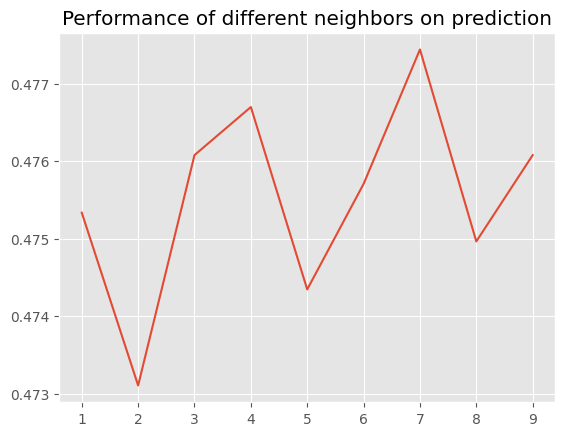

In [10]:
scores_iterImp = []

for i in range(1,10):
    imputer = IterativeImputer(random_state = 123, n_nearest_features = i)
    x_iterImp = pd.DataFrame(imputer.fit_transform(x_1), columns = x_1.columns)
    classifier = KNeighborsClassifier()
    classifier.fit(x_iterImp, train['Segmentation'])
    scores_iterImp.append(cross_val_score(classifier,x_iterImp, train['Segmentation'], cv = 10, scoring = 'accuracy').mean())

plt.plot(range(1,10),scores_iterImp)
plt.title('Performance of different neighbors on prediction')
plt.show()

In [18]:
###  CLASIFICACIÓN ES MAYOR, PUESTO QUE ES EL ACCURACY

scores_iterImp[np.argmax((scores_iterImp))] ### BEST SCORE OF ITERATIVE/MICE
scores_KnnImp[np.argmax((scores_KnnImp))] ### BEST SCORE OF KNN IMPUTER
scores_simpleImput[np.argmax((scores_simpleImput))] ### BEST SCORE OF SIMPLE IMPUTER

0.47657592836870927

In [19]:
### EL MÉTODO QUE MEJOR RESULTADO ARROJÓ FUE EL KNEAREST NEIHGBORS IMPUTER CON 2 VECINOS

imputer = KNNImputer(n_neighbors = 2) ## arreglar
x_KnnImp = pd.DataFrame(imputer.fit_transform(x_1), columns = x_1.columns)

## Modelos predictivos

In [24]:
X_train, X_test, y_train, y_test = train_test_split(x_KnnImp, y, test_size = 0.2, random_state = 1)

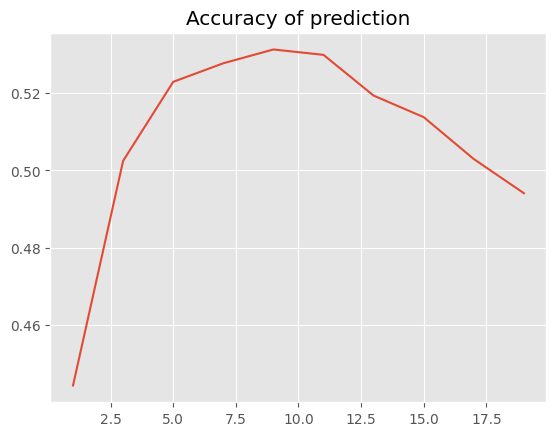

In [27]:
score_rf_clsf = []

for i in range(1,20,2):
    rf_clsf = RandomForestClassifier(max_depth = i)
    rf_clsf.fit(X_train,y_train)
    score_rf_clsf.append(cross_val_score(rf_clsf, X_train, y_train, scoring = 'accuracy', cv = 10).mean())

plt.plot(range(1,20,2),score_rf_clsf)
plt.title('Accuracy of prediction')
plt.show()

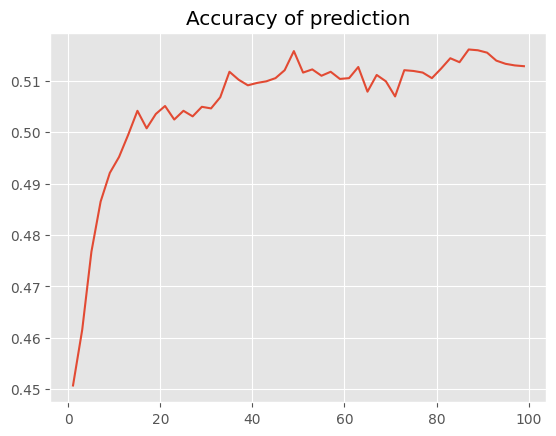

In [33]:
score_knn_clsf = []

for i in range(1,100,2):
    knn_clsf = KNeighborsClassifier(n_neighbors = i)
    knn_clsf.fit(X_train,y_train)
    score_knn_clsf.append(cross_val_score(knn_clsf, X_train, y_train, scoring = 'accuracy', cv = 10).mean())

plt.plot(range(1,100,2),score_knn_clsf)
plt.title('Accuracy of prediction')
plt.show()

## Reducción dimensionalidad

## Caracterización de los clientes por segmento